# Digits recognition with Keras

I will build a conventional Neural Network that recognizes handwriting digits using Keras API 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import keras
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9369650751326744231, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6662668288
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14638960966908209854
 physical_device_desc: "device: 0, name: GeForce GTX 1070 Ti, pci bus id: 0000:09:00.0, compute capability: 6.1"]

Tensorflow-GPU is working

## About the data

The MNIST database contains 60,000 training images and 10,000 testing images of digits written by high school students and employees of the United States Census Bureau.

In [3]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [4]:
X_train.shape

(60000, 28, 28)

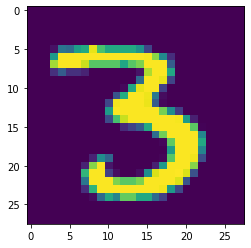

In [5]:
plt.imshow(X_train[12])

In [6]:
y_train[12]

3

## Train validation split

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=11)

## Preprocessing

With conventional neural networks I have to vectorize images:

In [8]:
num_pixels = X_train.shape[1] * X_train.shape[2]

X_train = X_train.reshape(X_train.shape[0], num_pixels)
X_test = X_test.reshape(X_test.shape[0], num_pixels)
X_val = X_val.reshape(X_val.shape[0], num_pixels)

In [9]:
X_train.shape

(48000, 784)

Let's also normalize the data:

In [10]:
X_train = X_train / X_train.max()
X_test = X_test / X_test.max()
X_val = X_val / X_val.max()

One hot encoding outputs:

In [11]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

## Building neural network

Since Keras have removed f1 score I will create a custom one:

In [12]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Building a model:

In [13]:
def classification_model():
    model = Sequential()
    model.add(Dense(num_pixels, activation="relu", input_shape=(num_pixels, )))
    model.add(Dense(100, activation="relu"))
    model.add(Dense(y_train.shape[1], activation="softmax"))    
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy', f1])
    return model

In [14]:
model = classification_model()

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, verbose=2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
 - 6s - loss: 0.2000 - accuracy: 0.9393 - f1: 0.9362 - val_loss: 0.1242 - val_accuracy: 0.9616 - val_f1: 0.9617
Epoch 2/10
 - 5s - loss: 0.0835 - accuracy: 0.9741 - f1: 0.9742 - val_loss: 0.1208 - val_accuracy: 0.9608 - val_f1: 0.9615
Epoch 3/10
 - 5s - loss: 0.0573 - accuracy: 0.9817 - f1: 0.9817 - val_loss: 0.0939 - val_accuracy: 0.9721 - val_f1: 0.9726
Epoch 4/10
 - 5s - loss: 0.0416 - accuracy: 0.9864 - f1: 0.9865 - val_loss: 0.0887 - val_accuracy: 0.9734 - val_f1: 0.9741
Epoch 5/10
 - 5s - loss: 0.0336 - accuracy: 0.9889 - f1: 0.9888 - val_loss: 0.1190 - val_accuracy: 0.9701 - val_f1: 0.9702
Epoch 6/10
 - 5s - loss: 0.0267 - accuracy: 0.9915 - f1: 0.9916 - val_loss: 0.1171 - val_accuracy: 0.9703 - val_f1: 0.9704
Epoch 7/10
 - 5s - loss: 0.0236 - accuracy: 0.9922 - f1: 0.9922 - val_loss: 0.1197 - val_accuracy: 0.9732 - val_f1: 0.9733
Epoch 8/10
 - 5s - loss: 0.0197 - accuracy: 0.9935 - f1: 0.9935 - val_loss: 0.1115 - val_

In [15]:
scores = model.evaluate(X_test, y_test, verbose=0)

In [16]:
accuracy, f1_scores = scores[1], scores[2]

print('Accuracy: {:.2f}%'.format(accuracy*100))
print('F1: {:.2f}%'.format(f1_scores*100))

Accuracy: 97.97%
F1: 98.01%


## Save the model

In [17]:
model.save('mnist_nn.h5')